## Problem formulation

This section defines a problem that the later section tries to solve. If
you want to go straight to the solving, see the sections:
[Monte Carlo integration](./monte_carlo_integration.ipynb),
[point collocation](./point_collocation.ipynb),
[pseudo-spectral projection](pseudo_spectral_projection.ipynb), and
[intrusive Galerkin](./intrusive_galerkin.ipynb). They all are based on the
problem described here.

At the core of any forward problem, stochastic or otherwise, you will find
the model predictor or model solver. Typically most problems starts with a
set of governing equations that needs to be solved. The model predictor will
in this case represent the forward predictor that allows the user to create
predictions. However as we are trying to address uncertain parameter, making
a single solution will likely not do. Instead the parameters needs to be an
input in the model predictor, and the governing equations have to be solved
specifically for the provided input.

In other words, we expect the model predictor to be deterministic. It should
typically expect some form of `parameters` vector as input. And to keep
things simple, we assume that the return value for the predictor is either
scalar or some sort of `numpy.ndarray` vector.

As these tutorials are all meant for demonstrative purposes only, we keep
things simple. We limit our problem to a simple ordinary linear equation:

$$
\tfrac{d}{dt} u(t, q) = - \beta u(t, q) \qquad u(0, q) = \alpha
$$

the number of parameters to two: initial condition $\alpha$ and rate $\beta$.
We define this model over the domain $t\in [0, 10]$. For simplicity and to
assess accuracy, we use the analytical solution to this problem:

In [1]:
import numpy

coordinates = numpy.linspace(0, 10, 1000)


def model_solver(parameters):
    """
    Simple ordinary differential equation solver.

    Args:
        parameters (numpy.ndarray):
            Hyper-parameters defining the model initial
            conditions alpha and growth rate beta.
            Assumed to have ``len(parameters) == 2``.

    Returns:
        (numpy.ndarray):
            Solution to the equation.
            Same shape as ``coordinates``.
    """
    alpha, beta = parameters
    return alpha*numpy.e**-(coordinates*beta)

We can then use the model by passing only the two model parameters:

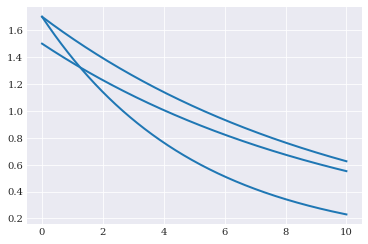

In [2]:
from matplotlib import pyplot

pyplot.plot(coordinates, model_solver([1.5, 0.1]))
pyplot.plot(coordinates, model_solver([1.7, 0.2]))
pyplot.plot(coordinates, model_solver([1.7, 0.1]))

pyplot.show()

Changing the model parameters changes the shape of the solution.

### Uncertain parameters

Even though `model_solver` is assumed to be deterministic, we are here going
to assume that there are uncertainty in the model parameters, which in turn
means there is uncertainty in the model.

For our  tiny example, we assume that the `parameters` can be described
through a bivariate uniform probability distribution:

In [3]:
import chaospy

alpha = chaospy.Normal(1.5, 0.2)
beta = chaospy.Uniform(0.1, 0.2)
joint = chaospy.J(alpha, beta)

This distribution can be visualized as follows:

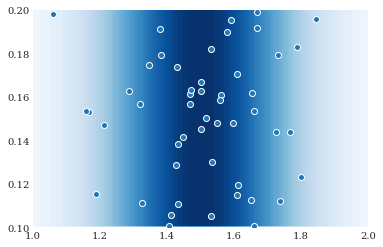

In [4]:
grid = numpy.mgrid[1:2:100j, 0.1:0.2:100j]
contour = pyplot.contourf(grid[0], grid[1], joint.pdf(grid), 50)

pyplot.scatter(*joint.sample(50, seed=1234))

pyplot.show()

### Model evaluations

Random samples created from the distribution can be passed to the model
solver, creating random realizations of the model solutions.

In [5]:
parameter_samples = joint.sample(10000, seed=1234)
model_evaluations = numpy.array([model_solver(sample)
                                for sample in parameter_samples.T])

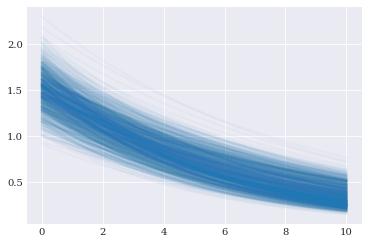

In [6]:
pyplot.plot(coordinates, model_evaluations[:1000].T, alpha=0.03)
pyplot.show()

### Reference solution

Our goal here is to describe the behavior of ``model_predictor`` with only
having a black-box evaluation of the function available.

To be able to assess how well the various methods works for this example, we
asses how well the various methods is to estimate the _mean_ and _variance_
for the model solution. To do so, we need the reference value to compare
against. For such a simple problem, this can be done analytically:

$$
 \begin{align*}
 \mbox E(u) =& \frac{15 (e^{-0.1t}-e^{-0.2t})}t &
 \mbox{Var}(u) =& \frac{11.45 (e^{-0.2t}\!-\!e^{-0.4t})}t - \mbox E(u)^2
 \end{align*}
$$

or numerically:

In [7]:
_t = coordinates[1:]

true_mean = numpy.hstack([
    1.5, 15*(numpy.e**(-0.1*_t)-numpy.e**(-0.2*_t))/_t])
true_variance = numpy.hstack([
    2.29, 11.45*(numpy.e**(-0.2*_t)-numpy.e**(-0.4*_t))/_t])-true_mean**2

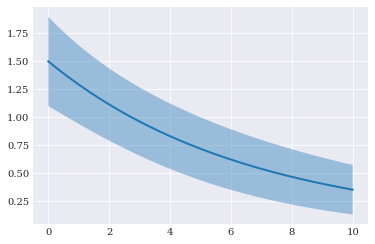

In [8]:
std = numpy.sqrt(true_variance)
pyplot.fill_between(coordinates, true_mean-2*std, true_mean+2*std, alpha=0.4)
pyplot.plot(coordinates, true_mean)
pyplot.show()

### Error analysis

To summarize how close a particular estimator is, we use the average absolute
difference between estimated and true value. We can create a couple of helper
functions to calculate this for us:

In [9]:
def error_in_mean(predicted_mean, true_mean=true_mean):
    """
    How close the estimated mean is the to the true mean.

    Args:
        predicted_mean (numpy.ndarray):
            The estimated mean.
        true_mean (numpy.ndarray):
            The reference mean value. Must be same shape as
            ``prediction_mean``.

    Returns:
        (float):
            The mean absolute distance between predicted
            and true values.
    """
    return numpy.mean(numpy.abs(predicted_mean-true_mean))

In [10]:
def error_in_variance(predicted_variance,
                      true_variance=true_variance):
    """
    How close the estimated variance is the to the true variance.

    Args:
        predicted_variance (numpy.ndarray):
            The estimated variance.
        true_variance (numpy.ndarray):
            The reference variance value.
            Must be same shape as ``predicted_variance``.

    Returns:
        (float):
            The mean absolute distance between
            predicted and true values.
    """
    return numpy.mean(numpy.abs(predicted_variance-true_variance))

Which we can apply to our little problem:

In [11]:
(error_in_mean(numpy.mean(model_evaluations[:100], 0)),
 error_in_variance(numpy.var(model_evaluations[:100], 0)))

(0.003705159671179502, 0.0006474753373452826)

In [12]:
indices = numpy.arange(100, 10001, 100, dtype=int)
eps_mean = [error_in_mean(numpy.mean(model_evaluations[:idx], 0))
            for idx in indices]
eps_variance = [error_in_variance(numpy.var(model_evaluations[:idx], 0))
                for idx in indices]

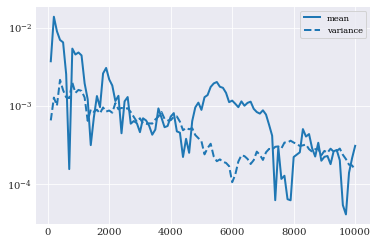

In [13]:
pyplot.semilogy(indices, eps_mean, "-", label="mean")
pyplot.semilogy(indices, eps_variance, "--", label="variance")
pyplot.legend()
pyplot.show()

This solution will be used as a reference in the later sections like:
[Monte Carlo integration](./monte_carlo_integration.ipynb),
[point collocation](./point_collocation.ipynb),
[pseudo-spectral projection](pseudo_spectral_projection.ipynb), and
[intrusive Galerkin](./intrusive_galerkin.ipynb).